In [3]:
! pip install pandas

In [4]:
! pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 46kB/s 


In [5]:
!pip install keras

In [7]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is NOT AVAILABLE


In [8]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AEb8ZYoGt0EmK9RNsqfRaMLW7xYMxv7-7BPAArR2Zx7upa9TDng7gM
Mounted at /content/drive


In [10]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/Colab Notebooks/Class/Dataset/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/Class/Dataset/test'

In [11]:
# Import the VGG19 library as shown below and add preprocessing layer to the front of VGG19",
# Here we will be using imagenet weights\n"
vgg= VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [12]:
# don't train existing weights\n",
for layer in vgg.layers:
    layer.trainable = False

In [13]:
# useful for getting number of output classes
folders = glob('/content/drive/My Drive/Colab Notebooks/Class/Dataset/train/*')
len(folders)

5

In [14]:
folders[0]

'/content/drive/My Drive/Colab Notebooks/Class/Dataset/train/maize cob'

In [15]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [16]:
prediction=Dense(len(folders), activation='softmax')(x)

In [17]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [18]:

# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [19]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Class/Dataset/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2501 images belonging to 5 classes.


In [22]:
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/Class/Dataset/test/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 525 images belonging to 5 classes.


In [23]:

# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=3,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
79/79 [==============================] - 1932s 24s/step - loss: 0.5868 - accuracy: 0.7949 - val_loss: 0.4234 - val_accuracy: 0.8476
Epoch 2/3
79/79 [==============================] - 1900s 24s/step - loss: 0.1926 - accuracy: 0.9352 - val_loss: 0.3297 - val_accuracy: 0.8895
Epoch 3/3
79/79 [==============================] - 1897s 24s/step - loss: 0.1142 - accuracy: 0.9688 - val_loss: 0.3036 - val_accuracy: 0.8857


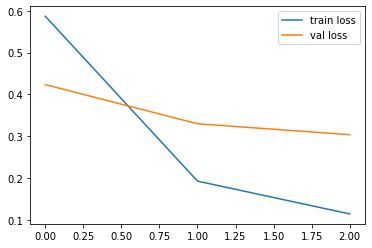

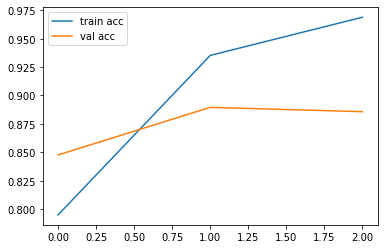

<Figure size 432x288 with 0 Axes>

In [24]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('class_model_vgg19.h5')

In [26]:
y_pred = model.predict(test_set)

In [28]:
y_pred

array([[3.4509423e-01, 4.0054354e-03, 4.4157550e-02, 5.9157670e-01,
        1.5166034e-02],
       [9.9987137e-01, 2.8514842e-05, 9.5456620e-05, 2.6525893e-06,
        2.0063796e-06],
       [1.7265595e-02, 4.2312210e-03, 9.0408716e-03, 9.6541005e-01,
        4.0522995e-03],
       ...,
       [9.9607038e-01, 2.2638610e-03, 6.9592707e-04, 6.8202388e-04,
        2.8766011e-04],
       [3.9295319e-08, 4.9953898e-03, 9.2725913e-06, 8.7845228e-06,
        9.9498653e-01],
       [6.7814370e-04, 3.4870198e-01, 3.2518379e-02, 6.1753666e-01,
        5.6488288e-04]], dtype=float32)

In [29]:

import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [30]:
y_pred

array([3, 0, 3, 4, 4, 4, 0, 1, 4, 4, 3, 0, 3, 1, 1, 2, 4, 1, 2, 2, 0, 4,
       3, 0, 4, 4, 2, 1, 2, 3, 2, 1, 0, 1, 4, 0, 3, 1, 2, 0, 1, 1, 4, 0,
       2, 2, 2, 1, 0, 2, 2, 2, 4, 3, 2, 0, 2, 2, 1, 0, 4, 3, 1, 4, 2, 4,
       1, 1, 1, 4, 4, 3, 2, 3, 4, 0, 3, 3, 0, 2, 0, 3, 0, 4, 1, 4, 0, 0,
       1, 2, 0, 3, 0, 1, 4, 2, 2, 1, 4, 1, 0, 0, 2, 2, 3, 0, 1, 2, 3, 2,
       3, 4, 1, 3, 2, 1, 2, 3, 2, 4, 0, 0, 4, 2, 0, 1, 2, 1, 0, 1, 0, 2,
       2, 3, 4, 1, 2, 3, 2, 2, 2, 2, 4, 1, 0, 2, 3, 0, 3, 4, 2, 2, 1, 2,
       3, 4, 1, 0, 0, 1, 0, 1, 0, 3, 3, 1, 3, 4, 1, 0, 3, 1, 0, 1, 4, 4,
       0, 0, 4, 3, 0, 0, 0, 4, 3, 1, 2, 3, 4, 1, 3, 2, 3, 4, 3, 3, 3, 2,
       2, 4, 3, 2, 4, 4, 3, 4, 2, 1, 0, 4, 1, 4, 1, 3, 0, 2, 1, 1, 1, 2,
       2, 0, 0, 0, 2, 0, 3, 3, 0, 3, 2, 4, 2, 1, 2, 2, 2, 2, 2, 2, 1, 4,
       0, 2, 2, 3, 1, 4, 2, 1, 4, 2, 2, 2, 0, 0, 0, 1, 0, 1, 4, 3, 2, 3,
       0, 0, 3, 2, 0, 3, 0, 2, 0, 2, 3, 3, 2, 0, 4, 3, 1, 1, 2, 3, 3, 1,
       2, 4, 2, 4, 2, 2, 2, 4, 0, 4, 3, 0, 4, 2, 1,

In [31]:
len(y_pred)

525

In [32]:
np.array(y_pred==1).sum()

97

In [52]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [53]:
model=load_model('class_model_vgg19.h5')

In [62]:
img=image.load_img('/content/drive/My Drive/Colab Notebooks/Class/Dataset/training/maize cob.jpg',target_size=(224,224))


In [63]:
y=image.img_to_array(img)
y


array([[[253., 254., 249.],
        [253., 254., 249.],
        [253., 254., 249.],
        ...,
        [205., 202., 197.],
        [207., 205., 190.],
        [209., 207., 182.]],

       [[253., 254., 249.],
        [253., 254., 249.],
        [253., 254., 249.],
        ...,
        [206., 202., 199.],
        [208., 206., 194.],
        [208., 207., 187.]],

       [[253., 254., 249.],
        [253., 254., 249.],
        [253., 254., 249.],
        ...,
        [206., 202., 199.],
        [208., 206., 194.],
        [208., 207., 187.]],

       ...,

       [[248., 246., 247.],
        [249., 247., 248.],
        [244., 243., 241.],
        ...,
        [ 26.,  18.,  15.],
        [ 26.,  18.,  15.],
        [ 26.,  18.,  15.]],

       [[248., 246., 247.],
        [249., 247., 248.],
        [244., 243., 241.],
        ...,
        [ 26.,  18.,  15.],
        [ 26.,  18.,  15.],
        [ 26.,  18.,  15.]],

       [[249., 247., 248.],
        [254., 252., 253.],
        [246., 2

In [64]:
y.shape

(224, 224, 3)

In [65]:
y=np.expand_dims(y,axis=0)
imgy=preprocess_input(y)
imgy.shape

(1, 224, 224, 3)

In [66]:
imgy=imgy/255

In [67]:
preds= model.predict(imgy)
preds[0]



array([4.9075634e-06, 2.2395889e-05, 9.9996603e-01, 2.1021551e-06,
       4.5835532e-06], dtype=float32)

In [68]:
a=np.argmax(preds, axis=1)
a

array([2])

In [69]:
if(a==0):
    print("cotton")
elif(a==1):
    print("Leaf")
elif(a==2):
    print("Maize Cob")
elif(a==3):
    print("Red Rose")
else:
  print("Sunflower")


Maize Cob
